In [1]:
import time
import datetime
import pickle
import itertools
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [3]:
@jit(nopython=True, cache=True)
def SERmodel_multneuro(NN, C, T, sp, refr, ia=1, d=0):
    """
    SER network simulation for multiple neurons in one region

    NN           = Number of neurons in a region
    C            = Matrix of coupling (NxN) between pairs of regions (can be directed)
    T            = Total time of simulated activity
    sp           = Probability of spontaneous firing between 0 and 1
    refr         = Probability to exit the refractory state between 0 and 1
    ia           = Initial condition setting. It can be a number representing the number
                 of excited nodes (the remaining nodes are splitted in two equal
                 size cohorts of susceptible and refractory nodes) or can be
                 a vector describing the initial state of each region
    d            = Initial time steps to remove (transient dynamics)

    Convention is:
          - susceptible node =  0
          - excited node     =  1
          - refractory node  = -1

    as a result, gives an activity for a particular matrix C under the SER dynamics
    for a given initial condition setting.
    """

    if T <= d:
        raise ValueError("Simulation time must be greater than the transient")

    if (len(ia) == 1 and ia.item() > len(C)) or (len(ia) > len(C)):
        raise ValueError(
            "Initial active nodes must be equal to or lower than the total number of nodes"
        )

    numb = NN  # number of neurons in a region
    N = len(C)  # number of regions
    y = np.zeros((numb, N, T)).astype(
        np.int64
    )  # initialize phase timeseries for one cycle

    ##Initialization

    for j in range(numb):
        if len(ia) == N:
            y[j, :, 0] = ia
        else:
            print("here")
            r4 = np.random.choice(np.arange(N), ia.item(), replace=False)
            k4 = y[j, :, 0]
            k4[r4] = 1
            y[j, :, 0] = k4
            r5 = np.where(y[j, :, 0] == 0)[0]
            k5 = y[j, :, 0]
            k5[r5] = np.floor(1 - 2 * np.random.uniform(0, 1, len(r5)))
            y[j, :, 0] = k5

    for t in range(T - 1):
        # updates for ser model
        for i in range(numb):

            r = y[i, :, t] == 1
            k = y[i, :, t + 1]
            k[r] = -1
            y[i, :, t + 1] = k

            r1 = np.logical_and(y[i, :, t] == 0, (np.sum(C[:, y[i, :, t] == 1], 1) > 0))
            k1 = y[i, :, t + 1]
            k1[r1] = 1
            y[i, :, t + 1] = k1

            r2 = np.logical_and(
                np.logical_and(
                    y[i, :, t] == 0, (np.sum(C[:, y[i, :, t] == 1], 1) <= 0)
                ),
                (np.random.uniform(0, 1, 12) < sp),
            )
            k2 = y[i, :, t + 1]
            k2[r2] = 1
            y[i, :, t + 1] = k2

            r3 = np.logical_and(
                y[i, :, t] == -1, (np.random.uniform(0, 1, 12) < (1 - refr))
            )
            k3 = y[i, :, t + 1]
            k3[r3] = -1
            y[i, :, t + 1] = k3

    fin = y[:, :, d:]

    return fin


In [4]:
##function to load pickles
def loadall(filename):
    '''Takes a filename, loads pickles'''
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break


# function to load pickles in form of an array
def pic_to_ar(name):
    '''Takes a filename, returns unpickled array'''
    items = loadall(name)
    c = list(items)
    c_ar = np.array(c)
    c_ar_sq = np.squeeze(c_ar)

    return c_ar_sq


# function to retrieve coactivation matrices
def coact(c_ar_sq):
    '''Takes unpickled array, returns coactivation matrix'''
    tr_for_high = c_ar_sq

    matr = np.zeros((len(tr_for_high), len(tr_for_high[0]), len(tr_for_high[0])))

    for numb in range(len(tr_for_high)):

        tr_for_high_first = tr_for_high[numb]

        cor_mat = np.zeros((len(tr_for_high_first), len(tr_for_high_first)))

        for i in range(len(tr_for_high_first)):
            for j in range(len(tr_for_high_first)):
                cor_mat[i, j] = (
                    np.sum(
                        np.logical_and(
                            tr_for_high_first[i, :] == 1, tr_for_high_first[j, :] == 1
                        )
                    )
                    / np.shape(tr_for_high_first)[1]
                )

        matr[numb] = cor_mat

    mean_matr_coactiv = np.mean(matr, axis=0)

    return mean_matr_coactiv

# function to get the repeating ends from the initial conditions
@jit(nopython=True, cache=True)
def attrs(chunk):
    '''Gets the repeating ends of the array'''
    c_ar_sq_us = chunk  # comment in and out for different conditions
    # nost = np.empty(1)

    steps_with_effects = 40  # transient period
    at_s = 3  # attractor size
    attrs = np.ones((np.shape(c_ar_sq_us)[0], 12, 3))

    for i in range(np.shape(c_ar_sq_us)[0]):
        loop_step = steps_with_effects
        while loop_step <= (np.shape(c_ar_sq_us)[2] - 2 * at_s):
            attractor = c_ar_sq_us[i][:, loop_step : loop_step + at_s]
            attractor_shift = c_ar_sq_us[i][:, loop_step + at_s : loop_step + 2 * at_s]
            loop_test = attractor == attractor_shift
            if loop_test.all() != 1:
                print("No stable attractor for condition ", i)
                break
            if loop_step == (np.shape(c_ar_sq_us)[2] - 2 * at_s):
                at = attractor
                attrs[i] = at
            loop_step += 1
    return attrs

# remove duplicates
def Extract(lst):
    '''Extracts first appearances from list'''
    return [item[0] for item in lst]


# find uniques
def Unique(lst):
    '''Finds unique items'''
    return [list(set(item)) for item in lst]


def in_list(c, classes):
    '''Returns -1 if c is contained in list'''
    for f, sublist in enumerate(classes):
        if c in sublist:
            return f
    return -1


# function to get all unique attractors
def un_roll(atr_list):
    '''Takes ends of an unpickled array, returns attractors of the system, their amount
    and the indices of the limit cycles'''
    no_at = 0  # no attractor of size 3 is defined
    fix_p0 = 0  # fixed point 0
    other = 0  # attractor of size 3
    indices_help = []

    for i in range(np.shape(atr_list)[0]):
        if ((atr_list[i] == 1).all()) == 1:
            no_at += 1
        if ((atr_list[i] == 0).all()) == 1:
            fix_p0 += 1
        if (((atr_list[i] == 1).all()) != 1) and ((atr_list[i] == 0).all()) != 1:
            other += 1
            indices_help.append(i)

    # create an arrray of all the attractors of size 3
    all_attractors = atr_list[indices_help]

    # calculate the number of unique attractors
    u_a = np.unique(all_attractors, axis=0)

    # calculate the counts of this attractors
    u_a_counts = np.unique(all_attractors, axis=0, return_counts=True)[-1]

    rollers = [[]]

    # need to check if in u_a any attractors which are just rolled versions of themselves
    for i in range(len(u_a)):
        for j in range(len(u_a)):
            if np.sum(u_a[i] == np.roll(u_a[j], 1, axis=1)) == 36:  # check rolled array
                k = in_list(i, rollers)
                q = in_list(j, rollers)
                if (k == -1) and (q == -1):
                    rollers.append([i, j])
                if (k == -1) and (q != -1):
                    rollers[q].append(i)
                    rollers.append([])
                if (k != -1) and (q == -1):
                    rollers[k].append(j)
                    rollers.append([])
                if (k != -1) and (q != -1):
                    # rollers[q].append(i)
                    # rollers[k].append(j)
                    rollers.append([])
        t = in_list(i, rollers)
        if t == -1:
            rollers.append([i])

    # remove empty lists
    rolled = [x for x in rollers if x != []]

    attractor_space = u_a[Extract(rolled), :, :]

    attractor_counts = np.zeros(len(attractor_space))

    for i in range(len(attractor_space)):
        attractor_counts[i] = np.sum(u_a_counts[Unique(rolled)[i]])

    return attractor_space, attractor_counts, indices_help

In [5]:
states = list(itertools.product([0, 1, -1], repeat=12))
states_ar = np.array(states)

# FoG healthy matrix
A1 = np.array(
    [
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
        [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, -1, -1, -1, 0, 0, 0, 0, -1, 0, -1, -1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1],
        [0, -1, 0, -1, -1, -1, 0, -1, -1, 0, -1, -1],
        [0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0],
        [0, 0, 0, 0, -1, 0, -1, -1, -1, 0, -1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, -1, 1, -1, -1, -1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    ]
)  # directed FOG network
# (LC,PRF,CNF,PPN,SNr,STN,GPi,GPe,Str,Ctx,SNc,Th)

T = 100  # time
NN = 1  # number of neurons

# parameters for the determenistic version of SER
sp = 0
refr = 1

In [7]:
name = f'Files/data_h_{datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")}.pckl'
file = open(name, "wb")

for i in range(len(states)):
    ## simulate all types
    res_h = SERmodel_multneuro(
        NN, A1.T, T, sp, refr, np.array(states[i])
    )  # results for healthy state directed graph/no dbs
    datalist = [res_h]

    ##write into a file
    pickle.dump(datalist, file)

file.close()

In [8]:
# convert to arrays
h = pic_to_ar(name)
# calculate attractors
attrs_h = attrs(h)

h_sp, h_c, indd_h = un_roll(attrs_h)

In [9]:
# new file for healthy attractors
name_at = (
    f'Files/attractors_h_{datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")}.pckl'
)
file_at = open(name_at, "wb")

pickle.dump(attrs_h, file_at)

file_at.close()

# attr h
name_sp = f'Files/space_h_{datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")}.pckl'
file_sp = open(name_sp, "wb")

name_c = f'Files/counts_h_{datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")}.pckl'
file_c = open(name_c, "wb")

pickle.dump([h_sp], file_sp)
pickle.dump([h_c], file_c)

file_c.close()
file_sp.close()

In [10]:
#%% calculate coactivation matrices
coact_h = coact(h[indd_h])



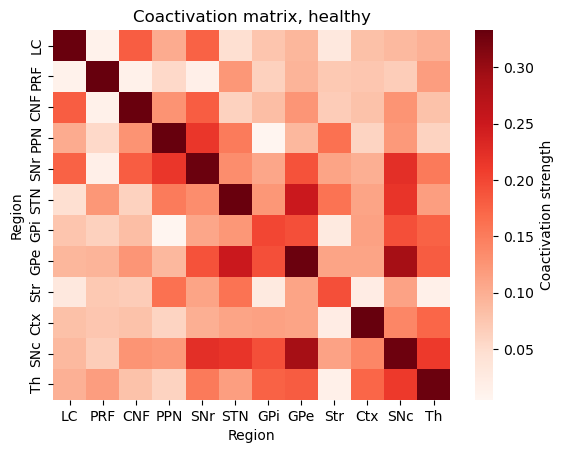

In [13]:
#%% plot coactivation matrices
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot

plot_state = [
    "LC",
    "PRF",
    "CNF",
    "PPN",
    "SNr",
    "STN",
    "GPi",
    "GPe",
    "Str",
    "Ctx",
    "SNc",
    "Th",
]
figure = pyplot.figure()
ax = sns.heatmap(
    coact_h,
    cbar_kws={"label": "Coactivation strength"},
    xticklabels=plot_state,
    yticklabels=plot_state,
cmap="Reds").set_title("Coactivation matrix, healthy")
plt.ylabel("Region")
plt.xlabel("Region")
plt.show()
